# <font  color = "#0093AF"> REDOR

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter3/Ch3_REDOR.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

Rotational-Echo DOuble Resonance NMR (REDOR$^1$) is an important technique for dynamics measurements,$^{2,3}$ where applying REDOR to one-bond dipole couplings allows one to compare the known size of the dipole coupling, to its measured size, which is smaller due to dynamics. This yields the order parameter, $S$, according to

$$
\begin{equation}
|S|=\left|\frac{\delta_{exp}}{\delta_{rigid}}\right|
\end{equation}
$$

We do not obtain the sign of the dipole coupling from REDOR, so we only get the absolute value of $S$. 

Here, we investigate how REDOR behaves as a function of correlation time.

Note, this was the topic of a recent paper by Aebischer et al.,$^4$ where simulations were performed using Gamma. We hope SLEEPY makes this type of simulation more accessible.

[1] T. Gullion, J. Schaefer. *[J. Magn. Reson.](https://doi.org/10.1016/0022-2364(89)90280-1)*, **1989**, 196-200.

[2] V. Chevelkov, U. Fink. B. Reif. *[J. Am. Chem. Soc.](https://doi.org/10.1021/ja902649u)*, **2009**, 131, 14018-14022.

[3] P. Schanda, B.H. Meier, M. Ernst. *[J. Magn. Reson.](https://doi.org/10.1016/j.jmr.2011.03.015)*, **2011**, 210, 246-259.

[4] K. Aebischer, L.M. Becker, P. Schanda, M. Ernst. *[Magn. Reson.](https://doi.org/10.5194/mr-5-69-2024)*, **2024**, 5, 69-86

## Setup

In [0]:
# SETUP SLEEPY

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Build the system
We construct a system undergoing 3-site symmetric exchange, in order to obtain a residual dipole coupling without asymmetry ($\eta$=0).

In [3]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=sl.PowderAvg('bcr20'),n_gamma=30)
# After varying the powder average and n_gamma
# a beta-average and 30 gamma angles were determined to be sufficient
delta=sl.Tools.dipole_coupling(.102,'15N','1H')
phi=35*np.pi/180

ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex,kex=sl.Tools.Setup3siteSym(ex0,tc=1e-9,phi=phi)

L=sl.Liouvillian(ex,kex=kex)

## Generate and plot pulse sequences
First half, refocusing, second half

In [4]:
v1=150e3 #100 kHz pulse
tp=1/v1/2 #pi/2 pulse length

t=[0,L.taur/2-tp,L.taur/2,L.taur-tp,L.taur]
first=L.Sequence().add_channel('1H',t=t,v1=[0,v1,0,v1],phase=[0,0,0,np.pi/2,0])
t=[0,tp,L.taur/2,L.taur/2+tp,L.taur]
second=L.Sequence().add_channel('1H',t=t,v1=[v1,0,v1,0],phase=[np.pi/2,0,0,0,0])
center=L.Sequence().add_channel('15N',t=[0,L.taur/2-tp/2,L.taur/2+tp/2,L.taur],
                               v1=[0,v1,0])

rho=sl.Rho('15Nx','15Nx')

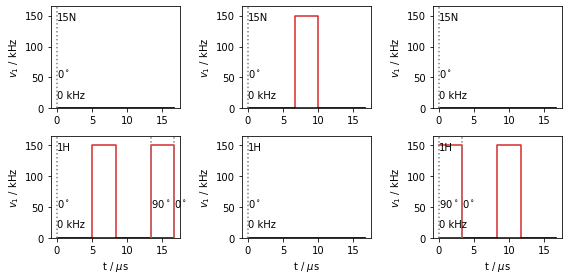

In [5]:
fig,ax=plt.subplots(2,3)
first.plot(ax=ax.T[0])
center.plot(ax=ax.T[1])
second.plot(ax=ax.T[2])
fig.set_size_inches([8,4])
fig.tight_layout()

## Propagation

In [6]:
Ucenter=center.U()
Ufirst=first.U()
Usecond=second.U()

In [7]:
rho=sl.Rho('15Nx','15Nx')
U1=L.Ueye()
U2=L.Ueye()

t0=time()
for k in range(32):
    rho.reset()
    (U2*Ucenter*U1*rho)()
    U1=Ufirst*U1
    U2=Usecond*U2
print(time()-t0)

53.852184772491455


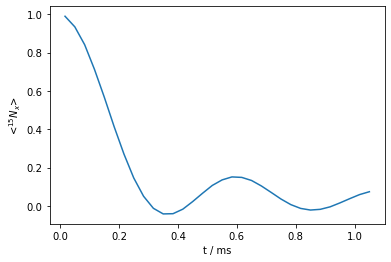

In [8]:
ax=rho.plot()

### Reducible sequence
The above sequence is computationally expensive, requiring a basis set of 48 elements. If we consider that we're mainly interested in the $S^+$ operator of the $^{15}$N spin, then its worth noting that the $^{15}$N $\pi$-pulse in the middle of the sequence converts $S^+$ into $S^-$, $S^\alpha$, and $S^\beta$, so that if we could get rid of it, we could use a basis set 1/4 as big (12 elements). Since there is no isotropic $^{15}$N shift included, we can switch the channel of the middle pulse to $^1$H. An alternative approach would be to use a $\delta$-pulse on $^{15}$N, although the basis set would then only be reduced to 24 elements, since $S^+$ would still be converted to $S^-$

In [9]:
centerH=L.Sequence().add_channel('1H',t=[0,L.taur/2-tp/2,L.taur/2+tp/2,L.taur],v1=[0,v1,0])

rho=sl.Rho('15Np','15Nx')

rho,f,s,c,Ueye=rho.ReducedSetup(first,second,centerH,L.Ueye())

State-space reduction: 48->12


In [10]:
Ufirst=f.U()
Usecond=s.U()
Ucenter=c.U()

In [11]:
U1=Ueye
U2=Ueye

t0=time()
for k in range(32):
    rho.reset()
    (U2*Ucenter*U1*rho)()
    U1=Ufirst*U1
    U2=Usecond*U2
print(time()-t0)

11.625831842422485


<AxesSubplot:xlabel='t / ms', ylabel='<$^{15}N_x$>'>

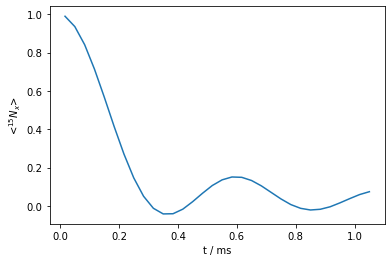

In [12]:
rho.plot()

## Sweep the correlation time
We now re-run the above setup, but while varying the correlation time to watch the transition between seeing only the averaged dipole coupling to seeing the rigid-limit coupling.

In [13]:
rho_list=[]
legend=[]
t0=time()
for tc in np.logspace(-6,-3,8):
    L.kex=sl.Tools.nSite_sym(n=3,tc=tc)

    t=[0,L.taur/2-tp,L.taur/2,L.taur-tp,L.taur]
    first=L.Sequence().add_channel('1H',t=t,v1=[0,v1,0,v1],phase=[0,0,0,np.pi/2])
    t=[0,tp,L.taur/2,L.taur/2+tp,L.taur]
    second=L.Sequence().add_channel('1H',t=t,v1=[v1,0,v1,0],phase=[0,0,np.pi/2,0])
    centerH=L.Sequence().add_channel('1H',t=[0,L.taur/2-tp/2,L.taur/2+tp/2,L.taur],v1=[0,v1,0])

    rho_list.append(sl.Rho('15Np','15Nx'))

    rho_list[-1],f,s,c,Ueye=rho_list[-1].ReducedSetup(first,second,centerH,L.Ueye())

    Ufirst=f.U()
    Usecond=s.U()
    Ucenter=c.U()

    U1=Ueye
    U2=Ueye

    for k in range(24):
        rho_list[-1].reset()
        (U2*Ucenter*U1*rho_list[-1])()
        
        U1=Ufirst*U1
        U2=Usecond*U2

    legend.append(fr'$\log_{{10}}(\tau_c)$ = {np.log10(tc):.1f}')
    print(f'log10(tc /s) = {np.log10(tc):.1f}, {time()-t0:.0f} seconds elapsed')

State-space reduction: 48->12
log10(tc /s) = -6.0, 11 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -5.6, 22 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -5.1, 33 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -4.7, 44 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -4.3, 55 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -3.9, 66 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -3.4, 78 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -3.0, 89 seconds elapsed


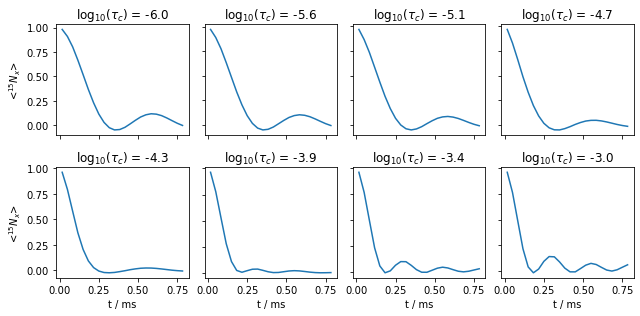

In [14]:
fig,ax=plt.subplots(2,4)
ax=ax.flatten()
for a,l,r in zip(ax,legend,rho_list):
    r.plot(ax=a)
    a.set_title(l)
    if not(a.is_first_col()):
        a.set_ylabel('')
        a.set_yticklabels([])
    if not(a.is_last_row()):
        a.set_xlabel('')
        a.set_xticklabels([])
fig.set_size_inches([9,4.5])
fig.tight_layout()

We observe above that when the correlation time is shorter than about 100 $\mu$s, we see the fulling averaged coupling, and when the correlation time is longer than about 1 ms, we obtain the rigid-limit value. In between, oscillations are damped due to dynamics being on the timescale of the coupling.